<div style="
    background-color: #f7f7f7;
    background-image: url(''), url('') ;
    background-position: left bottom, right top;
    background-repeat: no-repeat,  no-repeat;
    background-size: auto 60px, auto 160px;
    border-radius: 5px;
    box-shadow: 0px 3px 1px -2px rgba(0, 0, 0, 0.2), 0px 2px 2px 0px rgba(0, 0, 0, 0.14), 0px 1px 5px 0px rgba(0,0,0,.12);">

<h1 style="
    color: #2a4cdf;
    font-style: normal;
    font-size: 2.25rem;
    line-height: 1.4em;
    font-weight: 600;
    padding: 30px 200px 0px 30px;"> 
        Diversity Evolution Analysis</h1>

<p style="
    line-height: 1.4em;
    padding: 30px 200px 0px 30px;">
    This notebook analyzes the temporal evolution of material diversity in the Perovskite Solar Cell Database.</a>.  
</p>

<p style="font-size: 1.25em; font-style: italic; padding: 5px 200px 30px 30px;">
     Sherjeel Shabih, Hampus Näsström, Kevin Jablonka, and Pepe Márquez
</p>
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## 1. Load Data

In [4]:
# Load the database (adjust path as needed)
df = pd.read_parquet('perovskite_solar_cell_database.parquet')

# Extract key columns
df['pub_year'] = pd.to_datetime(
    df['data.ref.publication_date'], errors='coerce'
).dt.year
df['source'] = df['data.ref.extraction_method'].apply(
    lambda x: 'LLM' if x == 'LLM' else 'Manual'
)
df['absorber'] = df['results.properties.optoelectronic.solar_cell.absorber']
df['HTL'] = df['results.properties.optoelectronic.solar_cell.hole_transport_layer']
df['ETL'] = df['results.properties.optoelectronic.solar_cell.electron_transport_layer']
df['band_gap'] = pd.to_numeric(df['data.perovskite.band_gap'], errors='coerce')

print(
    f'Loaded {len(df):,} device records ({df["pub_year"].min():.0f}–{df["pub_year"].max():.0f})'
)
print(f'  Manual: {(df["source"] == "Manual").sum():,}')
print(f'  LLM:    {(df["source"] == "LLM").sum():,}')

Loaded 48,380 device records (2009–2025)
  Manual: 42,834
  LLM:    5,546


## 2. Define Helper Functions

In [5]:
def flatten_materials(series):
    """
    Flatten arrays of materials into a single list.
    The database stores materials as arrays (e.g., multiple HTL layers).
    """
    materials = []
    for arr in series.dropna():
        if hasattr(arr, '__iter__') and not isinstance(arr, str):
            materials.extend([str(m).strip() for m in arr])
    return materials


def compute_shannon_entropy(materials_list):
    """
    Compute Shannon entropy H = -Σ p_i log₂(p_i).
    Returns entropy in bits.
    """
    if not materials_list:
        return np.nan
    counts = Counter(materials_list)
    total = sum(counts.values())
    probabilities = [count / total for count in counts.values()]
    entropy = -sum(p * np.log2(p) for p in probabilities if p > 0)
    return entropy


def top_k_concentration(materials_list, k=1):
    """
    Compute the fraction of materials in the top-k most common.
    """
    if not materials_list:
        return np.nan
    counts = Counter(materials_list)
    total = sum(counts.values())
    sorted_counts = sorted(counts.values(), reverse=True)
    return sum(sorted_counts[:k]) / total


def get_top_material(materials_list):
    """Return the most common material and its share."""
    if not materials_list:
        return None, np.nan
    counts = Counter(materials_list)
    total = sum(counts.values())
    top_mat, top_count = counts.most_common(1)[0]
    return top_mat, top_count / total

## 3. Compute Diversity Metrics by Year

In [6]:
years = range(2012, 2026)
layers = ['absorber', 'HTL', 'ETL']

# Storage for results
entropy_data = []
cumulative_data = []
cumulative_materials = {layer: set() for layer in layers}
cumulative_devices = 0

for year in years:
    year_df = df[df['pub_year'] == year]
    n_devices = len(year_df)

    if n_devices < 10:
        continue

    cumulative_devices += n_devices

    year_record = {'year': year, 'n_devices': n_devices}
    cumul_record = {
        'year': year,
        'n_devices': n_devices,
        'cumulative_devices': cumulative_devices,
    }

    for layer in layers:
        materials = flatten_materials(year_df[layer])
        unique_materials = set(materials)

        # Entropy and concentration
        year_record[f'{layer}_entropy'] = compute_shannon_entropy(materials)
        year_record[f'{layer}_unique'] = len(unique_materials)
        year_record[f'{layer}_top1'] = top_k_concentration(materials, 1)

        # Cumulative discovery
        new_materials = unique_materials - cumulative_materials[layer]
        cumulative_materials[layer].update(unique_materials)
        cumul_record[f'{layer}_new'] = len(new_materials)
        cumul_record[f'{layer}_cumulative'] = len(cumulative_materials[layer])

    entropy_data.append(year_record)
    cumulative_data.append(cumul_record)

entropy_df = pd.DataFrame(entropy_data)
cumul_df = pd.DataFrame(cumulative_data)

# Display
print('Shannon Entropy by Year (bits):')
display(
    entropy_df[
        ['year', 'n_devices', 'absorber_entropy', 'HTL_entropy', 'ETL_entropy']
    ].round(2)
)

Shannon Entropy by Year (bits):


,year,n_devices,absorber_entropy,HTL_entropy,ETL_entropy
0,2012,19,0.30,0.77,1.40
1,2013,226,0.54,2.16,2.42
2,2014,1543,0.71,3.16,3.11
3,2015,3532,0.71,2.73,3.18
4,2016,6211,1.68,3.15,3.50
5,2017,8028,2.26,3.35,3.60
6,2018,10621,2.85,3.67,3.82
7,2019,10635,3.26,3.88,3.84
8,2020,1927,3.92,3.97,3.77
9,2021,951,4.04,4.32,3.78


## 4. Heaps' Law Analysis

Heaps' Law describes vocabulary growth: $V(n) = K \cdot n^\beta$

- $V$ = vocabulary size (unique materials)
- $n$ = corpus size (cumulative devices)
- $\beta < 1$ indicates sublinear growth (diminishing discovery rate)

In [7]:
heaps_params = {}

print("Heaps' Law Fit: V = K · n^β")
print('-' * 50)

for layer in layers:
    n = cumul_df['cumulative_devices'].values
    V = cumul_df[f'{layer}_cumulative'].values

    mask = (n > 0) & (V > 0)
    log_n = np.log(n[mask])
    log_V = np.log(V[mask])

    slope, intercept, r_value, p_value, std_err = stats.linregress(log_n, log_V)

    heaps_params[layer] = {
        'beta': slope,
        'beta_se': std_err,
        'K': np.exp(intercept),
        'R_squared': r_value**2,
        'p_value': p_value,
    }

    print(
        f'{layer:8s}:  β = {slope:.3f} ± {std_err:.3f},  R² = {r_value**2:.4f},  p = {p_value:.2e}'
    )

Heaps' Law Fit: V = K · n^β
--------------------------------------------------
absorber:  β = 0.770 ± 0.052,  R² = 0.9474,  p = 4.91e-09
HTL     :  β = 0.851 ± 0.016,  R² = 0.9958,  p = 1.20e-15
ETL     :  β = 0.748 ± 0.022,  R² = 0.9894,  p = 3.27e-13


## 5. Create Main Text Figure

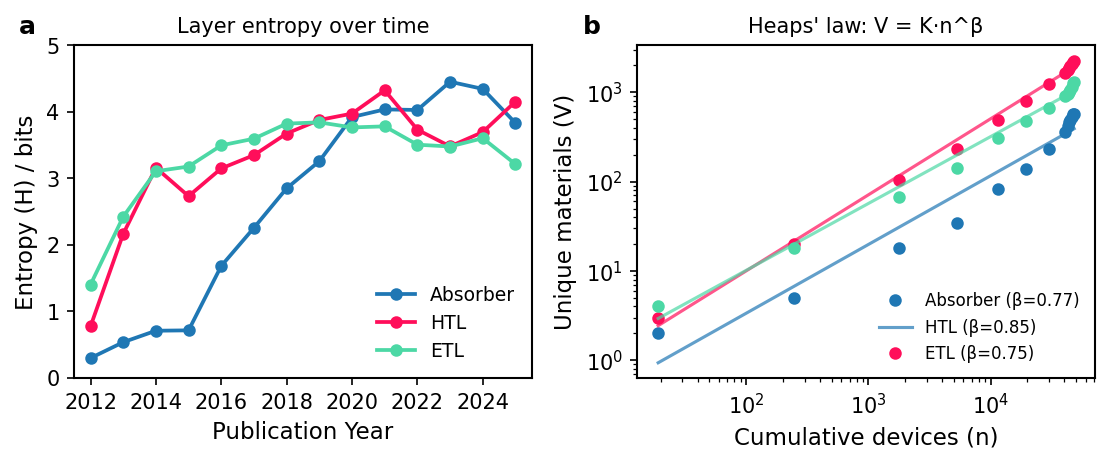


✓ Main figure saved as 'fig_diversity_evolution.pdf'


In [8]:
# Style configuration
plt.rcParams.update(
    {
        'font.size': 10,
        'axes.linewidth': 1,
        'axes.labelsize': 11,
        'legend.fontsize': 9,
        'figure.dpi': 150,
    }
)

colors = {
    'absorber': '#1f77b4',
    'HTL': '#ff0e5a',
    'ETL': '#4cd8a5',
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.5, 3.2))

# Panel A: Entropy
for layer in layers:
    label = 'Absorber' if layer == 'absorber' else layer
    ax1.plot(
        entropy_df['year'],
        entropy_df[f'{layer}_entropy'],
        'o-',
        color=colors[layer],
        label=label,
        linewidth=1.8,
        markersize=5,
    )

ax1.set_xlabel('Publication Year')
ax1.set_ylabel('Entropy (H) / bits')
ax1.set_title('Layer entropy over time', fontsize=10)
ax1.legend(frameon=False, loc='lower right')
ax1.set_xticks(range(2012, 2026, 2))
ax1.set_xlim(2011.5, 2025.5)
ax1.set_ylim(0, 5)
ax1.text(
    -0.12,
    1.02,
    'a',
    transform=ax1.transAxes,
    fontsize=12,
    fontweight='bold',
    va='bottom',
)

# Panel B: Heaps' Law
for layer in layers:
    n = cumul_df['cumulative_devices'].values
    V = cumul_df[f'{layer}_cumulative'].values
    ax2.loglog(n, V, 'o', color=colors[layer], markersize=5)

    params = heaps_params[layer]
    n_fit = np.logspace(np.log10(n.min()), np.log10(n.max()), 100)
    V_fit = params['K'] * n_fit ** params['beta']
    ax2.loglog(n_fit, V_fit, '-', color=colors[layer], linewidth=1.5, alpha=0.7)

ax2.set_xlabel('Cumulative devices (n)')
ax2.set_ylabel('Unique materials (V)')
ax2.set_title("Heaps' law: V = K·n^β", fontsize=10)
legend_labels = [
    f'Absorber (β={heaps_params["absorber"]["beta"]:.2f})',
    f'HTL (β={heaps_params["HTL"]["beta"]:.2f})',
    f'ETL (β={heaps_params["ETL"]["beta"]:.2f})',
]
ax2.legend(legend_labels, frameon=False, loc='lower right', fontsize=8)
ax2.text(
    -0.12,
    1.02,
    'b',
    transform=ax2.transAxes,
    fontsize=12,
    fontweight='bold',
    va='bottom',
)

plt.tight_layout()
fig.savefig('fig_diversity_evolution.pdf', bbox_inches='tight', dpi=300)
fig.savefig('fig_diversity_evolution.png', bbox_inches='tight', dpi=300)
plt.show()

print("\n✓ Main figure saved as 'fig_diversity_evolution.pdf'")

---
# Robustness Analysis

The following sections test whether the observed trends are robust to potential confounding factors:

1. **Methodology confounding**: Do trends exist within Manual-only data?
2. **Effect size argument**: Is the dominance decay too large to be a naming artifact?
3. **Rarefaction**: Do trends persist after controlling for sample size?
4. **Physical validation**: Does bandgap distribution confirm compositional broadening?

## 6. Test 1: Trends Within Manual Data Only (2012–2019)

In [9]:
# Compute metrics for Manual data only
manual_df = df[
    (df['source'] == 'Manual') & (df['pub_year'] >= 2012) & (df['pub_year'] <= 2019)
]

manual_metrics = []
for year in range(2012, 2020):
    year_df = manual_df[manual_df['pub_year'] == year]
    if len(year_df) < 50:
        continue

    mats = flatten_materials(year_df['absorber'])
    top_mat, top_share = get_top_material(mats)

    manual_metrics.append(
        {
            'year': year,
            'n_devices': len(year_df),
            'absorber_entropy': compute_shannon_entropy(mats),
            'absorber_top1': top_k_concentration(mats, 1),
            'top_material': top_mat,
            'top_share': top_share,
        }
    )

manual_metrics_df = pd.DataFrame(manual_metrics)

# Linear regression for entropy trend
slope, intercept, r, p, se = stats.linregress(
    manual_metrics_df['year'], manual_metrics_df['absorber_entropy']
)

print('Absorber Entropy Trend (Manual Data Only, 2012-2019)')
print('=' * 55)
print(f'  Slope:     {slope:.3f} bits/year')
print(f'  R²:        {r**2:.3f}')
print(f'  p-value:   {p:.2e}')
print(
    f'  Result:    {"SIGNIFICANT" if p < 0.01 else "Not significant"} increasing trend'
)
print()
display(
    manual_metrics_df[
        ['year', 'n_devices', 'absorber_entropy', 'top_material', 'top_share']
    ].round(3)
)

Absorber Entropy Trend (Manual Data Only, 2012-2019)
  Slope:     0.499 bits/year
  R²:        0.949
  p-value:   2.05e-04
  Result:    SIGNIFICANT increasing trend



,year,n_devices,absorber_entropy,top_material,top_share
0,2013,226,0.537,MAPbI,0.912
1,2014,1543,0.709,MAPbI,0.911
2,2015,3532,0.715,MAPbI,0.915
3,2016,6211,1.683,MAPbI,0.782
4,2017,8028,2.257,MAPbI,0.683
5,2018,10621,2.850,MAPbI,0.582
6,2019,10561,3.250,MAPbI,0.468


## 8. Test 2: Rarefaction Analysis

Control for sample size effects by subsampling to equal N and computing entropy with bootstrap confidence intervals.

In [10]:
n_subsample = 500
n_bootstrap = 100
rarefaction_years = [2014, 2016, 2018, 2019, 2020, 2022, 2024]

rarefaction_results = []

for year in rarefaction_years:
    year_df = df[df['pub_year'] == year]
    if len(year_df) < n_subsample:
        continue

    entropies = []
    for _ in range(n_bootstrap):
        sample = year_df.sample(n=n_subsample, replace=False)
        mats = flatten_materials(sample['absorber'])
        entropies.append(compute_shannon_entropy(mats))

    rarefaction_results.append(
        {
            'year': year,
            'entropy_mean': np.mean(entropies),
            'entropy_std': np.std(entropies),
            'entropy_ci_low': np.percentile(entropies, 2.5),
            'entropy_ci_high': np.percentile(entropies, 97.5),
        }
    )

rarefaction_df = pd.DataFrame(rarefaction_results)

print(f'Rarefaction Analysis (N={n_subsample}, {n_bootstrap} bootstrap replicates)')
print('=' * 55)
print('\n  Year  | Entropy (mean ± std)  | 95% CI')
print('  ------|----------------------|----------------')
for _, row in rarefaction_df.iterrows():
    print(
        f'  {row["year"]:.0f}  |   {row["entropy_mean"]:.2f} ± {row["entropy_std"]:.2f}         | [{row["entropy_ci_low"]:.2f}, {row["entropy_ci_high"]:.2f}]'
    )

print(f'\n  → Entropy increase persists after controlling for sample size.')

Rarefaction Analysis (N=500, 100 bootstrap replicates)

  Year  | Entropy (mean ± std)  | 95% CI
  ------|----------------------|----------------
  2014  |   0.69 ± 0.07         | [0.58, 0.85]
  2016  |   1.60 ± 0.11         | [1.41, 1.80]
  2018  |   2.72 ± 0.11         | [2.49, 2.92]
  2019  |   3.07 ± 0.12         | [2.86, 3.30]
  2020  |   3.81 ± 0.11         | [3.61, 4.04]
  2022  |   3.95 ± 0.08         | [3.81, 4.10]
  2024  |   4.24 ± 0.09         | [4.08, 4.41]

  → Entropy increase persists after controlling for sample size.


## 9. Test 3: Physical Validation via Bandgap Distribution

Bandgap is a measured physical quantity unaffected by naming conventions. If absorber diversification is real, the bandgap distribution should broaden beyond MAPbI₃'s characteristic ~1.55–1.60 eV.

In [11]:
bandgap_stats = []

periods = [
    ('2012-2015', 2012, 2015),
    ('2016-2018', 2016, 2018),
    ('2019-2021', 2019, 2021),
    ('2022-2025', 2022, 2025),
]

print('Bandgap Distribution Statistics')
print('=' * 65)
print('\n  Period     | N (valid) | Mean (eV) | Std (eV) | IQR (eV)')
print('  -----------|-----------|-----------|----------|----------')

for period_name, y_start, y_end in periods:
    mask = (df['pub_year'] >= y_start) & (df['pub_year'] <= y_end)
    bg = df.loc[mask, 'band_gap'].dropna()

    if len(bg) > 50:
        iqr = bg.quantile(0.75) - bg.quantile(0.25)
        bandgap_stats.append(
            {
                'period': period_name,
                'n': len(bg),
                'mean': bg.mean(),
                'std': bg.std(),
                'iqr': iqr,
            }
        )
        print(
            f'  {period_name}  | {len(bg):>9,} | {bg.mean():>9.3f} | {bg.std():>8.3f} | {iqr:>8.3f}'
        )

bandgap_stats_df = pd.DataFrame(bandgap_stats)

print(
    f'\n  → Bandgap std increased from {bandgap_stats_df["std"].iloc[0]:.3f} to {bandgap_stats_df["std"].iloc[-1]:.3f} eV'
)
print(f'  → This physical measurement confirms compositional diversification.')

Bandgap Distribution Statistics

  Period     | N (valid) | Mean (eV) | Std (eV) | IQR (eV)
  -----------|-----------|-----------|----------|----------
  2012-2015  |     5,099 |     1.600 |    0.089 |    0.000
  2016-2018  |    19,481 |     1.606 |    0.115 |    0.000
  2019-2021  |     8,525 |     1.628 |    0.168 |    0.010
  2022-2025  |     4,370 |     1.597 |    0.184 |    0.050

  → Bandgap std increased from 0.089 to 0.184 eV
  → This physical measurement confirms compositional diversification.


## 10. Create Supplementary Figure

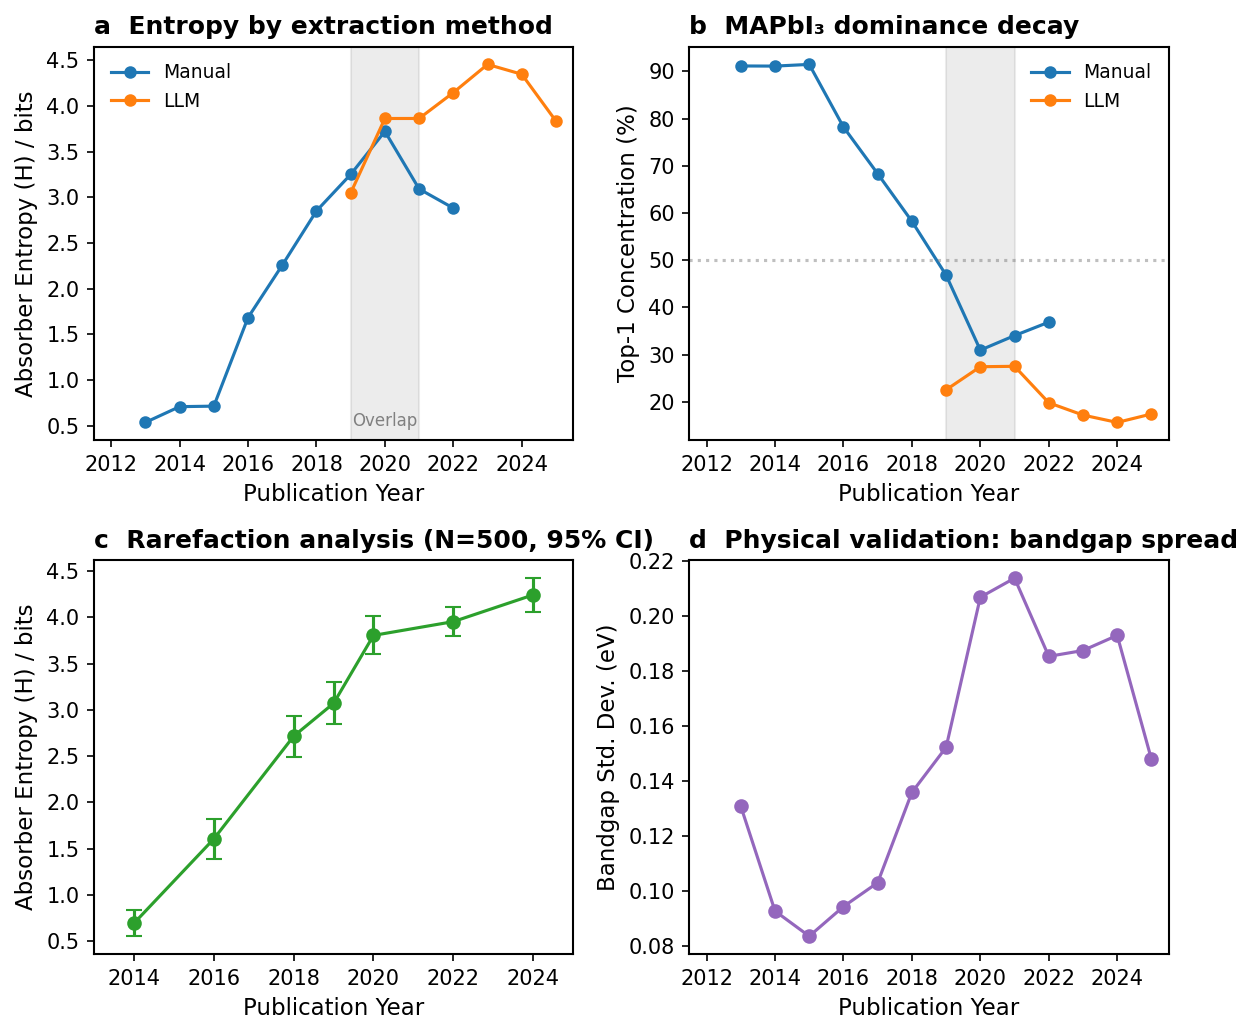


✓ Supplementary figure saved as 'fig_SI_robustness.pdf'


In [12]:
fig, axes = plt.subplots(2, 2, figsize=(8, 7))

colors_method = {'Manual': '#1f77b4', 'LLM': '#ff7f0e'}

# Compute metrics by year and source for panels a,b
method_results = []
for year in range(2012, 2026):
    for source in ['Manual', 'LLM']:
        year_df = df[(df['pub_year'] == year) & (df['source'] == source)]
        if len(year_df) < 30:
            continue
        mats = flatten_materials(year_df['absorber'])
        method_results.append(
            {
                'year': year,
                'source': source,
                'entropy': compute_shannon_entropy(mats),
                'top1': top_k_concentration(mats, 1),
            }
        )
method_df = pd.DataFrame(method_results)

# Panel A: Entropy by extraction method
ax = axes[0, 0]
for source in ['Manual', 'LLM']:
    sdf = method_df[method_df['source'] == source]
    ax.plot(
        sdf['year'],
        sdf['entropy'],
        'o-',
        color=colors_method[source],
        label=source,
        linewidth=1.5,
        markersize=5,
    )
ax.axvspan(2019, 2021, alpha=0.15, color='gray')
ax.set_xlabel('Publication Year')
ax.set_ylabel('Absorber Entropy (H) / bits')
ax.set_title('a  Entropy by extraction method', loc='left', fontweight='bold')
ax.legend(frameon=False)
ax.set_xlim(2011.5, 2025.5)
ax.annotate('Overlap', xy=(2020, 0.5), fontsize=8, color='gray', ha='center')

# Panel B: Top-1 concentration by method
ax = axes[0, 1]
for source in ['Manual', 'LLM']:
    sdf = method_df[method_df['source'] == source]
    ax.plot(
        sdf['year'],
        sdf['top1'] * 100,
        'o-',
        color=colors_method[source],
        label=source,
        linewidth=1.5,
        markersize=5,
    )
ax.axhline(50, color='gray', linestyle=':', alpha=0.5)
ax.axvspan(2019, 2021, alpha=0.15, color='gray')
ax.set_xlabel('Publication Year')
ax.set_ylabel('Top-1 Concentration (%)')
ax.set_title('b  MAPbI₃ dominance decay', loc='left', fontweight='bold')
ax.legend(frameon=False)
ax.set_xlim(2011.5, 2025.5)

# Panel C: Rarefaction
ax = axes[1, 0]
ax.errorbar(
    rarefaction_df['year'],
    rarefaction_df['entropy_mean'],
    yerr=rarefaction_df['entropy_std'] * 1.96,
    fmt='o-',
    color='#2ca02c',
    capsize=4,
    linewidth=1.5,
    markersize=6,
)
ax.set_xlabel('Publication Year')
ax.set_ylabel('Absorber Entropy (H) / bits')
ax.set_title(
    f'c  Rarefaction analysis (N={n_subsample}, 95% CI)', loc='left', fontweight='bold'
)
ax.set_xlim(2013, 2025)

# Panel D: Bandgap spread
ax = axes[1, 1]
bg_yearly = []
for year in range(2012, 2026):
    bg = df[df['pub_year'] == year]['band_gap'].dropna()
    if len(bg) > 50:
        bg_yearly.append({'year': year, 'std': bg.std()})
bg_yearly_df = pd.DataFrame(bg_yearly)
ax.plot(
    bg_yearly_df['year'],
    bg_yearly_df['std'],
    'o-',
    color='#9467bd',
    linewidth=1.5,
    markersize=6,
)
ax.set_xlabel('Publication Year')
ax.set_ylabel('Bandgap Std. Dev. (eV)')
ax.set_title('d  Physical validation: bandgap spread', loc='left', fontweight='bold')
ax.set_xlim(2011.5, 2025.5)

plt.tight_layout()
fig.savefig('fig_SI_robustness.pdf', bbox_inches='tight', dpi=300)
fig.savefig('fig_SI_robustness.png', bbox_inches='tight', dpi=300)
plt.show()

print("\n✓ Supplementary figure saved as 'fig_SI_robustness.pdf'")

---
## 11. Generate Supplementary Information Tables

In [13]:
import os

# Create SI directory
os.makedirs('SI_tables', exist_ok=True)

# ============================================================================
# TABLE S1: Yearly diversity metrics
# ============================================================================
table_s1 = entropy_df[
    [
        'year',
        'n_devices',
        'absorber_entropy',
        'absorber_unique',
        'absorber_top1',
        'HTL_entropy',
        'HTL_unique',
        'HTL_top1',
        'ETL_entropy',
        'ETL_unique',
        'ETL_top1',
    ]
].copy()

table_s1.columns = [
    'Year',
    'N_devices',
    'Absorber_H_bits',
    'Absorber_unique',
    'Absorber_top1_frac',
    'HTL_H_bits',
    'HTL_unique',
    'HTL_top1_frac',
    'ETL_H_bits',
    'ETL_unique',
    'ETL_top1_frac',
]

table_s1.to_csv(
    'SI_tables/Table_S1_yearly_diversity_metrics.csv', index=False, float_format='%.3f'
)
print('✓ Table S1: Yearly diversity metrics')

# ============================================================================
# TABLE S2: Cumulative material discovery
# ============================================================================
table_s2 = cumul_df[
    [
        'year',
        'n_devices',
        'cumulative_devices',
        'absorber_new',
        'absorber_cumulative',
        'HTL_new',
        'HTL_cumulative',
        'ETL_new',
        'ETL_cumulative',
    ]
].copy()

table_s2.columns = [
    'Year',
    'N_devices',
    'Cumulative_devices',
    'Absorber_new',
    'Absorber_cumulative',
    'HTL_new',
    'HTL_cumulative',
    'ETL_new',
    'ETL_cumulative',
]

table_s2.to_csv('SI_tables/Table_S2_cumulative_discovery.csv', index=False)
print('✓ Table S2: Cumulative material discovery')

# ============================================================================
# TABLE S3: Heaps' law parameters
# ============================================================================
table_s3 = pd.DataFrame(heaps_params).T
table_s3.index.name = 'Layer'
table_s3 = table_s3[['beta', 'beta_se', 'K', 'R_squared', 'p_value']]
table_s3.columns = ['Beta', 'Beta_SE', 'K', 'R_squared', 'p_value']
table_s3.to_csv('SI_tables/Table_S3_heaps_law_parameters.csv', float_format='%.4f')
print("✓ Table S3: Heaps' law parameters")

# ============================================================================
# TABLE S4: Robustness - Manual data only trend
# ============================================================================
table_s4 = manual_metrics_df.copy()
table_s4.columns = [
    'Year',
    'N_devices',
    'Absorber_H_bits',
    'Absorber_top1_frac',
    'Top_material',
    'Top_material_share',
]
table_s4.to_csv(
    'SI_tables/Table_S4_manual_only_metrics.csv', index=False, float_format='%.3f'
)
print('✓ Table S4: Manual data only metrics')

# ============================================================================
# TABLE S5: Rarefaction results
# ============================================================================
table_s5 = rarefaction_df.copy()
table_s5['n_subsample'] = n_subsample
table_s5['n_bootstrap'] = n_bootstrap
table_s5.columns = [
    'Year',
    'Entropy_mean',
    'Entropy_std',
    'CI_low_2.5',
    'CI_high_97.5',
    'N_subsample',
    'N_bootstrap',
]
table_s5.to_csv(
    'SI_tables/Table_S5_rarefaction_analysis.csv', index=False, float_format='%.3f'
)
print('✓ Table S5: Rarefaction analysis')

# ============================================================================
# TABLE S6: Bandgap distribution by period
# ============================================================================
table_s6 = bandgap_stats_df.copy()
table_s6.columns = [
    'Period',
    'N_valid',
    'Bandgap_mean_eV',
    'Bandgap_std_eV',
    'Bandgap_IQR_eV',
]
table_s6.to_csv(
    'SI_tables/Table_S6_bandgap_statistics.csv', index=False, float_format='%.4f'
)
print('✓ Table S6: Bandgap distribution statistics')

# ============================================================================
# TABLE S7: Statistical tests summary
# ============================================================================
slope_ent, _, r_ent, p_ent, se_ent = stats.linregress(
    manual_metrics_df['year'], manual_metrics_df['absorber_entropy']
)
slope_top1, _, r_top1, p_top1, se_top1 = stats.linregress(
    manual_metrics_df['year'], manual_metrics_df['absorber_top1']
)

table_s7 = pd.DataFrame(
    [
        {
            'Test': 'Entropy trend (Manual 2012-2019)',
            'Statistic': 'Linear regression slope',
            'Value': slope_ent,
            'SE': se_ent,
            'R_squared': r_ent**2,
            'p_value': p_ent,
            'Interpretation': 'Significant increasing trend',
        },
        {
            'Test': 'Top-1 concentration trend (Manual 2012-2019)',
            'Statistic': 'Linear regression slope',
            'Value': slope_top1,
            'SE': se_top1,
            'R_squared': r_top1**2,
            'p_value': p_top1,
            'Interpretation': 'Significant decreasing trend',
        },
    ]
)
table_s7.to_csv(
    'SI_tables/Table_S7_statistical_tests.csv', index=False, float_format='%.4e'
)
print('✓ Table S7: Statistical tests summary')

print('\n' + '=' * 60)
print("All SI tables saved to 'SI_tables/' directory")
print('=' * 60)

✓ Table S1: Yearly diversity metrics
✓ Table S2: Cumulative material discovery
✓ Table S3: Heaps' law parameters
✓ Table S4: Manual data only metrics
✓ Table S5: Rarefaction analysis
✓ Table S6: Bandgap distribution statistics
✓ Table S7: Statistical tests summary

All SI tables saved to 'SI_tables/' directory
